# Project Name - Identifying Suitable Residences in Toronto considering individual's preferences

<b>IBM Data Science Specialztion - Coursera</b><br>
Week 5 assignment

Md Ibtehajul Islam<br>
Email: iibtehajul@gmail.com<br>
LinkedIn: islam-md-ibtehajul<br>

## Importing libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
import xlrd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

print('Matplotlib version: ',mpl.__version__)

print('Folium installed')
print('Libraries imported.')

Matplotlib version:  3.0.3
Folium installed
Libraries imported.


### Defining Foursquare Credentials and Version

In [2]:
CLIENT_ID = '3ZUUVXNGIARZ1AEEBO1Y3OY3SKGRM3TKUNRMBXIVW3UK4415' # your Foursquare ID
CLIENT_SECRET = 'H2W3F5ZQYTT4EOY0ERCCATDMA1RC4E4W0BFTMWI5MGC0AWV2' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

### Defining the centre location of interest (Work Place Location)

In [4]:
address = '301 Front St W, Toronto, ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6425637 -79.38708718320467


### Defining the category of interest near the location 

In [5]:
search_query = 'Apartment'
radius = 5000
print(search_query + ' .... OK!')

Apartment .... OK!


### Generating url and json map from Foursquare API

In [6]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=3ZUUVXNGIARZ1AEEBO1Y3OY3SKGRM3TKUNRMBXIVW3UK4415&client_secret=H2W3F5ZQYTT4EOY0ERCCATDMA1RC4E4W0BFTMWI5MGC0AWV2&ll=43.6425637,-79.38708718320467&v=20180604&query=Apartment&radius=5000&limit=30'

In [7]:
results = requests.get(url).json()
#results

### Finding all the venues around the selected location & structuring into a dataframe

In [8]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
print(dataframe.shape)
dataframe.head()

(30, 17)


,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,[],False,5364e2f6498e2cafa29810aa,73 Richmond St. West,CA,Toronto,Canada,NaN,988,"[73 Richmond St. West, Toronto ON M5H 1Z4, Can...","[{'label': 'display', 'lat': 43.6508178710938,...",43.650818,-79.382559,M5H 1Z4,ON,Financial District Furnished Apartment,v-1591519145
1,"[{'id': '4bf58dd8d48988d1f8941735', 'name': 'F...",False,5dd3206d4e5a2b0008ded559,238 Queen St E,CA,Toronto,Canada,NaN,2010,"[238 Queen St E, Toronto ON M5A 1S3, Canada]","[{'label': 'display', 'lat': 43.654736, 'lng':...",43.654736,-79.368650,M5A 1S3,ON,The Apartment,v-1591519145
2,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4ad4c05bf964a5209df520e3,77 Ryerson Ave,CA,Toronto,Canada,NaN,1507,"[77 Ryerson Ave, Toronto ON M5T 2V4, Canada]","[{'label': 'display', 'lat': 43.65006053050052...",43.650061,-79.402669,M5T 2V4,ON,Alexandra Apartment Hotel,v-1591519145
3,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",False,4e040bb0b61c7592ae6e588b,16 willison sq,CA,Toronto,Canada,spandina AVe,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...","[{'label': 'display', 'lat': 43.65216840171611...",43.652168,-79.398821,M5T 1E8,ON,University Apartment,v-1591519145
4,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",False,542cc75a498e68715daf6f88,822-65 Scadding Avenue,CA,Toronto,Canada,NaN,1926,"[822-65 Scadding Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.648552, 'lng':...",43.648552,-79.364645,NaN,ON,Mark's Downtown Apartment,v-1591519145


In [9]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head(30)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Financial District Furnished Apartment,None,73 Richmond St. West,CA,Toronto,Canada,NaN,988,"[73 Richmond St. West, Toronto ON M5H 1Z4, Can...","[{'label': 'display', 'lat': 43.6508178710938,...",43.650818,-79.382559,M5H 1Z4,ON,5364e2f6498e2cafa29810aa
1,The Apartment,Furniture / Home Store,238 Queen St E,CA,Toronto,Canada,NaN,2010,"[238 Queen St E, Toronto ON M5A 1S3, Canada]","[{'label': 'display', 'lat': 43.654736, 'lng':...",43.654736,-79.368650,M5A 1S3,ON,5dd3206d4e5a2b0008ded559
2,Alexandra Apartment Hotel,Hotel,77 Ryerson Ave,CA,Toronto,Canada,NaN,1507,"[77 Ryerson Ave, Toronto ON M5T 2V4, Canada]","[{'label': 'display', 'lat': 43.65006053050052...",43.650061,-79.402669,M5T 2V4,ON,4ad4c05bf964a5209df520e3
3,University Apartment,Residential Building (Apartment / Condo),16 willison sq,CA,Toronto,Canada,spandina AVe,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...","[{'label': 'display', 'lat': 43.65216840171611...",43.652168,-79.398821,M5T 1E8,ON,4e040bb0b61c7592ae6e588b
4,Mark's Downtown Apartment,Residential Building (Apartment / Condo),822-65 Scadding Avenue,CA,Toronto,Canada,NaN,1926,"[822-65 Scadding Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.648552, 'lng':...",43.648552,-79.364645,NaN,ON,542cc75a498e68715daf6f88
5,Lieutenant-Governors Apartment - Queen's Park,Capitol Building,NaN,CA,NaN,Canada,NaN,2196,[Canada],"[{'label': 'display', 'lat': 43.66229767427558...",43.662298,-79.386956,NaN,NaN,4fca7852e4b0c116823a6344
6,Ahil's Apartment,Residential Building (Apartment / Condo),NaN,CA,NaN,Canada,NaN,2691,[Canada],"[{'label': 'display', 'lat': 43.66392238830782...",43.663922,-79.402740,NaN,NaN,5633e92b498ea61bed39e5a8
7,Executive Underground Apartment,Motel,NaN,CA,Toronto,Canada,NaN,2659,"[Toronto ON, Canada]","[{'label': 'display', 'lat': 43.66460709453357...",43.664607,-79.374359,NaN,ON,55921ad9498eac424b83ef9d
8,Alen's Apartment,Residential Building (Apartment / Condo),NaN,CA,NaN,Canada,NaN,2960,[Canada],"[{'label': 'display', 'lat': 43.642075, 'lng':...",43.642075,-79.423836,NaN,NaN,587258da1b36d47bd132a190
9,Alexey Apartment,None,"105, Isabella street, #1003",CA,Toronto,Canada,Ted Rogers street,2924,"[105, Isabella street, #1003 (Ted Rogers stree...","[{'label': 'display', 'lat': 43.66824206187538...",43.668242,-79.379413,NaN,ON,4e6ed00e1520a936fa5a69b7


In [10]:
df =dataframe_filtered 
df.shape

(30, 15)

### Keepking only the residencial venues

In [11]:
new_df = df[(df.categories == 'Residence') 
            | (df.categories == 'Assisted Living') 
            | (df.categories == 'Home (private)') 
            | (df.categories == 'Housing Development') 
            | (df.categories == 'Residential Building (Apartment / Condo)')]
print(new_df.shape)
new_df.head(17)

(18, 15)


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
3,University Apartment,Residential Building (Apartment / Condo),16 willison sq,CA,Toronto,Canada,spandina AVe,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...","[{'label': 'display', 'lat': 43.65216840171611...",43.652168,-79.398821,M5T 1E8,ON,4e040bb0b61c7592ae6e588b
4,Mark's Downtown Apartment,Residential Building (Apartment / Condo),822-65 Scadding Avenue,CA,Toronto,Canada,NaN,1926,"[822-65 Scadding Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.648552, 'lng':...",43.648552,-79.364645,NaN,ON,542cc75a498e68715daf6f88
6,Ahil's Apartment,Residential Building (Apartment / Condo),NaN,CA,NaN,Canada,NaN,2691,[Canada],"[{'label': 'display', 'lat': 43.66392238830782...",43.663922,-79.402740,NaN,NaN,5633e92b498ea61bed39e5a8
8,Alen's Apartment,Residential Building (Apartment / Condo),NaN,CA,NaN,Canada,NaN,2960,[Canada],"[{'label': 'display', 'lat': 43.642075, 'lng':...",43.642075,-79.423836,NaN,NaN,587258da1b36d47bd132a190
11,Furnished Apartment Rentals Toronto,Residential Building (Apartment / Condo),99 Yorkville Ave #200,CA,Toronto,Canada,NaN,3170,"[99 Yorkville Ave #200, Toronto ON M5R 1C1, Ca...","[{'label': 'display', 'lat': 43.67083323373386...",43.670833,-79.391889,M5R 1C1,ON,5d53b16c66378f0008e1d91f
12,RodXtein Apartment,Residential Building (Apartment / Condo),650 Parliament Street,CA,Toronto,Canada,Wellesley,3262,"[650 Parliament Street (Wellesley), Toronto ON...","[{'label': 'display', 'lat': 43.66973713399206...",43.669737,-79.371923,M4X 1R3,ON,5503658c498e74610f7b1203
15,Dufferin Park Apartment,Residential Building (Apartment / Condo),919 Dufferin Street,CA,Toronto,Canada,NaN,4127,"[919 Dufferin Street, Toronto ON M6H 4B3, Canada]","[{'label': 'display', 'lat': 43.65728286810229...",43.657283,-79.434124,M6H 4B3,ON,515e285ce4b0510b074acdff
16,Bunker Apartment,Residential Building (Apartment / Condo),630 St Clair av W,CA,Toronto,Canada,NaN,5289,"[630 St Clair av W, Toronto ON M6G 2Y2, Canada]","[{'label': 'display', 'lat': 43.68197, 'lng': ...",43.681970,-79.423780,M6G 2Y2,ON,582fc9cc80e1af60b2dea71e
18,His Super Sexy Apartment!,Residential Building (Apartment / Condo),NaN,CA,NaN,Canada,NaN,6068,[Canada],"[{'label': 'display', 'lat': 43.69638, 'lng': ...",43.696380,-79.399081,NaN,NaN,514fb458e4b091941c353289
19,Gem Apartments,Residential Building (Apartment / Condo),NaN,CA,Toronto,Canada,NaN,1198,"[Toronto ON M5T 1C2, Canada]","[{'label': 'display', 'lat': 43.651061, 'lng':...",43.651061,-79.396230,M5T 1C2,ON,5e2250268297730008926e6b


In [12]:
new_df.drop(['categories', 'cc', 'city', 'country', 'crossStreet', 'labeledLatLngs','state','id'], axis = 1, inplace = True)
new_df.rename(columns={'name':'Apt_Name', 'address':'Address', 'distance':'Distance_(in_meter)', 'formattedAddress':'Formatted_Address',\
                      'lat':'Latitude', 'lng':'Longitude', 'postalCode':'Postalcode'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [13]:
new_df = new_df.dropna()
new_df.sort_values(by=['Distance_(in_meter)'], axis=0, ascending=True, inplace=True)

In [14]:
new_df = new_df.reset_index(drop=True)
print(new_df.shape)
new_df

(11, 7)


,Apt_Name,Address,Distance_(in_meter),Formatted_Address,Latitude,Longitude,Postalcode
0,University Apartment,16 willison sq,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...",43.652168,-79.398821,M5T 1E8
1,Elm Place Apartments,222 Elm St.,1576,"[222 Elm St. (Elm & Mccaul), Toronto ON M5T 1K...",43.656243,-79.392139,M5T 1K5
2,Allan Plaza Apartments,166 Carlton Street,2568,"[166 Carlton Street, Toronto ON M5A 2K5, Canada]",43.663463,-79.373573,M5A 2K5
3,Furnished Apartment Rentals Toronto,99 Yorkville Ave #200,3170,"[99 Yorkville Ave #200, Toronto ON M5R 1C1, Ca...",43.670833,-79.391889,M5R 1C1
4,RodXtein Apartment,650 Parliament Street,3262,"[650 Parliament Street (Wellesley), Toronto ON...",43.669737,-79.371923,M4X 1R3
5,Kings Garden Apartments,345 Dufferin Street,3267,"[345 Dufferin Street, Toronto ON M6K, Canada]",43.640568,-79.427551,M6K
6,Avenue Park Apartments,103 Avenue Road,3401,"[103 Avenue Road, Toronto ON M5R 2G5, Canada]",43.672530,-79.395359,M5R 2G5
7,Dufferin Park Apartment,919 Dufferin Street,4127,"[919 Dufferin Street, Toronto ON M6H 4B3, Canada]",43.657283,-79.434124,M6H 4B3
8,CAPREIT Apartments,1 Oriole Rd,5065,"[1 Oriole Rd (Yonge & St Clair), Toronto ON M4...",43.687081,-79.400096,M4V 2C8
9,Bunker Apartment,630 St Clair av W,5289,"[630 St Clair av W, Toronto ON M6G 2Y2, Canada]",43.681970,-79.423780,M6G 2Y2


In [15]:
new_df.dtypes

Apt_Name                object
Address                 object
Distance_(in_meter)      int64
Formatted_Address       object
Latitude               float64
Longitude              float64
Postalcode              object
dtype: object

In [16]:
new_df['Postalcode'] =  new_df['Postalcode'].str.split(' ').apply(pd.Series)\
    .merge(new_df, left_index = True, right_index = True)\
    .drop(["Postalcode", 1], axis = 1)
new_df.head()

,Apt_Name,Address,Distance_(in_meter),Formatted_Address,Latitude,Longitude,Postalcode
0,University Apartment,16 willison sq,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...",43.652168,-79.398821,M5T
1,Elm Place Apartments,222 Elm St.,1576,"[222 Elm St. (Elm & Mccaul), Toronto ON M5T 1K...",43.656243,-79.392139,M5T
2,Allan Plaza Apartments,166 Carlton Street,2568,"[166 Carlton Street, Toronto ON M5A 2K5, Canada]",43.663463,-79.373573,M5A
3,Furnished Apartment Rentals Toronto,99 Yorkville Ave #200,3170,"[99 Yorkville Ave #200, Toronto ON M5R 1C1, Ca...",43.670833,-79.391889,M5R
4,RodXtein Apartment,650 Parliament Street,3262,"[650 Parliament Street (Wellesley), Toronto ON...",43.669737,-79.371923,M4X


### Adding and merging the Toronto(Postal code and Borough) data with residential venue data

In [17]:
df_lat_long = pd.read_csv('List of postal codes of Canada_with_Latlong.csv')
df_lat_long.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [18]:
df_lat_long_P = df_lat_long.drop(['Neighbourhood','Latitude', 'Longitude'], axis = 1)
print('Shape of the Data Frame',df_lat_long_P.shape)
print('Name of the Boroughs: ',df_lat_long_P['Borough'].unique())
df_lat_long_P.head()

Shape of the Data Frame (103, 2)
Name of the Boroughs:  ['Scarborough' 'North York' 'East York' 'East Toronto' 'Central Toronto'
 'Downtown Toronto' 'York' 'West Toronto' 'Mississauga' 'Etobicoke'
 "Queen's Park"]


,Postalcode,Borough
0,M1B,Scarborough
1,M1C,Scarborough
2,M1E,Scarborough
3,M1G,Scarborough
4,M1H,Scarborough


In [19]:
df_final = pd.merge(new_df, df_lat_long_P, on = 'Postalcode')

In [20]:
print(df_final['Borough'].unique())

['Downtown Toronto' 'Central Toronto' 'West Toronto' 'York']


In [21]:
df_final

,Apt_Name,Address,Distance_(in_meter),Formatted_Address,Latitude,Longitude,Postalcode,Borough
0,University Apartment,16 willison sq,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...",43.652168,-79.398821,M5T,Downtown Toronto
1,Elm Place Apartments,222 Elm St.,1576,"[222 Elm St. (Elm & Mccaul), Toronto ON M5T 1K...",43.656243,-79.392139,M5T,Downtown Toronto
2,Allan Plaza Apartments,166 Carlton Street,2568,"[166 Carlton Street, Toronto ON M5A 2K5, Canada]",43.663463,-79.373573,M5A,Downtown Toronto
3,Furnished Apartment Rentals Toronto,99 Yorkville Ave #200,3170,"[99 Yorkville Ave #200, Toronto ON M5R 1C1, Ca...",43.670833,-79.391889,M5R,Central Toronto
4,Avenue Park Apartments,103 Avenue Road,3401,"[103 Avenue Road, Toronto ON M5R 2G5, Canada]",43.672530,-79.395359,M5R,Central Toronto
5,RodXtein Apartment,650 Parliament Street,3262,"[650 Parliament Street (Wellesley), Toronto ON...",43.669737,-79.371923,M4X,Downtown Toronto
6,Kings Garden Apartments,345 Dufferin Street,3267,"[345 Dufferin Street, Toronto ON M6K, Canada]",43.640568,-79.427551,M6K,West Toronto
7,Dufferin Park Apartment,919 Dufferin Street,4127,"[919 Dufferin Street, Toronto ON M6H 4B3, Canada]",43.657283,-79.434124,M6H,West Toronto
8,CAPREIT Apartments,1 Oriole Rd,5065,"[1 Oriole Rd (Yonge & St Clair), Toronto ON M4...",43.687081,-79.400096,M4V,Central Toronto
9,Bunker Apartment,630 St Clair av W,5289,"[630 St Clair av W, Toronto ON M6G 2Y2, Canada]",43.681970,-79.423780,M6G,Downtown Toronto


# Exploratory data analysis: (By Apartments)

### Analyzing the distances of the apartments from the center of location

In [22]:
new_df_dis = new_df[['Apt_Name', 'Distance_(in_meter)']]
new_df_dis.set_index('Apt_Name', inplace = True)
new_df_dis.head()

,Distance_(in_meter)
Apt_Name,
University Apartment,1427
Elm Place Apartments,1576
Allan Plaza Apartments,2568
Furnished Apartment Rentals Toronto,3170
RodXtein Apartment,3262


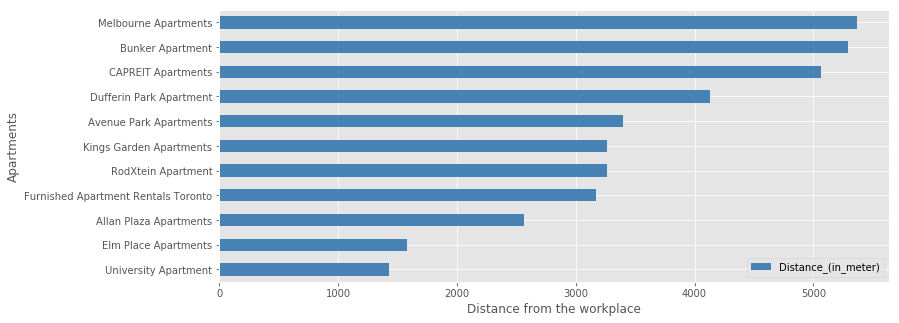

In [23]:
# plotting the bar graph 
new_df_dis.plot(kind = 'barh', figsize = (12,5), color= 'steelblue')
plt.xlabel('Distance from the workplace')
plt.ylabel('Apartments')

plt.show()

### Using analysis based on the apartments

In [24]:
map_new_toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add a red circle marker to represent the workplace
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Location of interest',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_new_toronto)

# add markers to map
for lat, lng, borough, apt_name, postalcode in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough'], df_final['Apt_Name'], df_final['Postalcode']):
    label = '{}, {}, {}'.format(apt_name, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new_toronto)  
    
map_new_toronto


### Getting nearby venues around the residencial places

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Apt. Name', 
                  'Apt. Latitude', 
                  'Apt. Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####  Creating a new dataframe called *Toronto_venues* by runnig the above function on it's each residencial places

In [26]:
toronto_venues = getNearbyVenues(names=df_final['Apt_Name'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude'],
                                   radius=5000
                                  )

University Apartment
Elm Place Apartments
Allan Plaza Apartments
Furnished Apartment Rentals Toronto
Avenue Park Apartments
RodXtein Apartment
Kings Garden Apartments
Dufferin Park Apartment
CAPREIT Apartments
Bunker Apartment
Melbourne Apartments


#### Checking the size of the resulting dataframe

In [27]:
print(toronto_venues.shape)
toronto_venues.head()

(1100, 7)


,Apt. Name,Apt. Latitude,Apt. Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,University Apartment,43.652168,-79.398821,Sonic Boom,43.650859,-79.396985,Record Shop
1,University Apartment,43.652168,-79.398821,Essence of Life Organics,43.654111,-79.400431,Organic Grocery
2,University Apartment,43.652168,-79.398821,Kid Icarus,43.653933,-79.401719,Arts & Crafts Store
3,University Apartment,43.652168,-79.398821,Maker Pizza,43.650401,-79.398040,Pizza Place
4,University Apartment,43.652168,-79.398821,Alo,43.648574,-79.396243,French Restaurant


#### Checking how many venues were returned for each neighborhood

In [28]:
toronto_venues.groupby(['Apt. Name', ]).count()

,Apt. Latitude,Apt. Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Apt. Name,,,,,,
Allan Plaza Apartments,100,100,100,100,100,100
Avenue Park Apartments,100,100,100,100,100,100
Bunker Apartment,100,100,100,100,100,100
CAPREIT Apartments,100,100,100,100,100,100
Dufferin Park Apartment,100,100,100,100,100,100
Elm Place Apartments,100,100,100,100,100,100
Furnished Apartment Rentals Toronto,100,100,100,100,100,100
Kings Garden Apartments,100,100,100,100,100,100
Melbourne Apartments,100,100,100,100,100,100


#### Finding out the number of unique categories can be curated from all the returned venues

In [29]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 105 uniques categories.


## Analyzing Each Residencial places

In [30]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Apt. Name'] = toronto_venues['Apt. Name'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Apt. Name,American Restaurant,Art Gallery,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,University Apartment,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print('The data frame size is {}'.format(toronto_onehot.shape))

The data frame size is (1100, 106)


#### Next, grouping rows by Residencial places and by taking the mean of the frequency of occurrence of each category

In [32]:
toronto_apt_grouped = toronto_onehot.groupby('Apt. Name').mean().reset_index()
toronto_apt_grouped.head()

,Apt. Name,American Restaurant,Art Gallery,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,...,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Allan Plaza Apartments,0.01,0.01,0.01,0.01,0.00,0.00,0.02,0.00,0.01,...,0.00,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.0
1,Avenue Park Apartments,0.01,0.01,0.01,0.00,0.00,0.00,0.03,0.00,0.00,...,0.01,0.00,0.02,0.00,0.01,0.00,0.01,0.00,0.00,0.0
2,Bunker Apartment,0.00,0.01,0.01,0.00,0.00,0.01,0.02,0.03,0.00,...,0.01,0.00,0.02,0.01,0.00,0.01,0.00,0.01,0.00,0.0
3,CAPREIT Apartments,0.00,0.01,0.01,0.00,0.01,0.02,0.02,0.01,0.00,...,0.01,0.00,0.02,0.01,0.00,0.01,0.00,0.00,0.01,0.0
4,Dufferin Park Apartment,0.00,0.01,0.01,0.00,0.00,0.00,0.05,0.04,0.00,...,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.01,0.00,0.0


In [33]:
print('The new data frame size is {}'.format(toronto_apt_grouped.shape))

The new data frame size is (11, 106)


#### Printing each residencial place along with the top 5 most common venues

In [34]:
num_apt_top_venues = 10

for hood in toronto_apt_grouped['Apt. Name']:
    print("----"+hood+"----")
    temp = toronto_apt_grouped[toronto_apt_grouped['Apt. Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_apt_top_venues))
    print('\n')

----Allan Plaza Apartments----
               venue  freq
0        Coffee Shop  0.13
1               Park  0.10
2         Restaurant  0.04
3  French Restaurant  0.03
4               Café  0.03
5     Farmers Market  0.03
6      Historic Site  0.03
7             Bakery  0.02
8              Diner  0.02
9              Plaza  0.02


----Avenue Park Apartments----
                venue  freq
0         Coffee Shop  0.08
1                Park  0.08
2                Café  0.05
3      Sandwich Place  0.04
4                 Spa  0.03
5              Bakery  0.03
6  Mexican Restaurant  0.03
7        Dessert Shop  0.03
8       Historic Site  0.02
9        Dance Studio  0.02


----Bunker Apartment----
                       venue  freq
0                       Café  0.12
1         Italian Restaurant  0.08
2                       Park  0.08
3                Coffee Shop  0.06
4                 Restaurant  0.03
5              Grocery Store  0.03
6                        Bar  0.03
7  Middle Eastern Restau

#### Putting that into a *pandas* dataframe by write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating the new dataframe and display the top 10 venues for each Residential building.

In [36]:
num_apt_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Apt. Name']
for ind in np.arange(num_apt_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_apt_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_apt_venues_sorted['Apt. Name'] = toronto_apt_grouped['Apt. Name']

for ind in np.arange(toronto_apt_grouped.shape[0]):
    neighbourhoods_apt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_apt_grouped.iloc[ind, :], num_apt_top_venues)

#neighbourhoods_venues_sorted.set_index('Apt. Name', inplace = True)    
#neighbourhoods_apt_venues_sorted.to_csv("neighbourhoods_venues_sorted.csv")
neighbourhoods_apt_venues_sorted

,Apt. Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allan Plaza Apartments,Coffee Shop,Park,Restaurant,Café,Historic Site,Farmers Market,French Restaurant,Gastropub,Sandwich Place,Diner
1,Avenue Park Apartments,Park,Coffee Shop,Café,Sandwich Place,Mexican Restaurant,Spa,Dessert Shop,Bakery,Historic Site,Pizza Place
2,Bunker Apartment,Café,Italian Restaurant,Park,Coffee Shop,Grocery Store,Bar,Restaurant,Brewery,Beer Bar,Japanese Restaurant
3,CAPREIT Apartments,Café,Park,Coffee Shop,Italian Restaurant,Supermarket,Grocery Store,Gastropub,Spa,Bagel Shop,Dessert Shop
4,Dufferin Park Apartment,Park,Café,Bakery,Bar,Coffee Shop,Sandwich Place,Brewery,Pizza Place,Ice Cream Shop,Scenic Lookout
5,Elm Place Apartments,Park,Coffee Shop,Bakery,Sandwich Place,Bookstore,Plaza,Pizza Place,Historic Site,Neighborhood,Gastropub
6,Furnished Apartment Rentals Toronto,Coffee Shop,Park,Café,Sandwich Place,Bakery,Mexican Restaurant,Dessert Shop,Tapas Restaurant,Spa,Grocery Store
7,Kings Garden Apartments,Park,Coffee Shop,Bakery,Bar,Café,Pizza Place,Brewery,Sandwich Place,Dog Run,Ice Cream Shop
8,Melbourne Apartments,Park,Café,Coffee Shop,Italian Restaurant,Bar,Bakery,Grocery Store,Pizza Place,Brewery,Beer Bar
9,RodXtein Apartment,Coffee Shop,Park,Restaurant,Italian Restaurant,Farmers Market,Historic Site,Bakery,Café,Gym / Fitness Center,Grocery Store


# Results (By Apartments/Residential Buildings)

## Inquiring for a specific amenities for residential buildings

In [37]:
inquiry = 'Grocery Store'
neighbourhoods_apt_venues_sorted[neighbourhoods_apt_venues_sorted['Apt. Name'].notnull() 
                            &(neighbourhoods_apt_venues_sorted['1st Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['2nd Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['3rd Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['4th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['5th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['6th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['7th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['8th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['9th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['10th Most Common Venue'] == inquiry)
                             
                            ]

,Apt. Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bunker Apartment,Café,Italian Restaurant,Park,Coffee Shop,Grocery Store,Bar,Restaurant,Brewery,Beer Bar,Japanese Restaurant
3,CAPREIT Apartments,Café,Park,Coffee Shop,Italian Restaurant,Supermarket,Grocery Store,Gastropub,Spa,Bagel Shop,Dessert Shop
6,Furnished Apartment Rentals Toronto,Coffee Shop,Park,Café,Sandwich Place,Bakery,Mexican Restaurant,Dessert Shop,Tapas Restaurant,Spa,Grocery Store
8,Melbourne Apartments,Park,Café,Coffee Shop,Italian Restaurant,Bar,Bakery,Grocery Store,Pizza Place,Brewery,Beer Bar
9,RodXtein Apartment,Coffee Shop,Park,Restaurant,Italian Restaurant,Farmers Market,Historic Site,Bakery,Café,Gym / Fitness Center,Grocery Store


#  _********************END of Apartments/Residencial Buildings Analysis********************_

# Exploratory data analysis: (By Neighborhoods)

### Finding all the neighbourhoods in those Boroughs in Toronto

In [38]:
toronto_borough = ['Downtown Toronto', 'West Toronto','Central Toronto']
toronto_df = df_lat_long[df_lat_long['Borough'].isin(toronto_borough)].reset_index(drop = True)
print(toronto_df.shape)
toronto_df.head()


(34, 5)


,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [39]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 3 boroughs and 34 neighbourhoods.


#### Using analysis based on neighbourhoods

In [40]:
map_new_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add a red circle marker to represent the workplace
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Location of interest',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_new_toronto)

# add markers to map
for lat, lng, borough, neighbourhood, postalcode in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood'], toronto_df['Postalcode']):
    label = '{}, {}, {}'.format(neighbourhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new_toronto)  
    
map_new_toronto

### Creating the new dataframe and display the top 10 venues for each Neighborhoods.

In [41]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####  Creating a new dataframe called *toronto_neighbourhood_venues* by runnig the above function on it's each neighborhood

In [42]:
toronto_neighbourhood_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'],
                                   radius=500
                                  )

Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction South
Parkdale, Roncesvalles
Runnymede, Swansea
Queen's Park


In [43]:
print(toronto_neighbourhood_venues.shape)
print(toronto_neighbourhood_venues['Neighbourhood'].unique())
toronto_neighbourhood_venues.head()

(1487, 7)
['Lawrence Park' 'Davisville North' 'North Toronto West' 'Davisville'
 'Moore Park, Summerhill East'
 'Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West'
 'Rosedale' 'Cabbagetown, St. James Town' 'Church and Wellesley'
 'Harbourfront' 'Ryerson, Garden District' 'St. James Town' 'Berczy Park'
 'Central Bay Street' 'Adelaide, King, Richmond'
 'Harbourfront East, Toronto Islands, Union Station'
 'Design Exchange, Toronto Dominion Centre'
 'Commerce Court, Victoria Hotel' 'Roselawn'
 'Forest Hill North, Forest Hill West'
 'The Annex, North Midtown, Yorkville' 'Harbord, University of Toronto'
 'Chinatown, Grange Park, Kensington Market'
 'CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara'
 'Stn A PO Boxes 25 The Esplanade'
 'First Canadian Place, Underground city' 'Christie'
 'Dovercourt Village, Dufferin' 'Little Portugal, Trinity'
 'Brockton, Exhibition Place, Parkdale Village'
 'High Park, The Junction Sou

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


#### checking how many venues were returned for each neighborhood

In [44]:
toronto_neighbourhood_venues.groupby(['Neighbourhood', ]).count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",93,93,93,93,93,93
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",24,24,24,24,24,24
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
"Cabbagetown, St. James Town",46,46,46,46,46,46
Central Bay Street,64,64,64,64,64,64
"Chinatown, Grange Park, Kensington Market",58,58,58,58,58,58
Christie,17,17,17,17,17,17
Church and Wellesley,79,79,79,79,79,79


#### Finding out the number of unique categories can be curated from all the returned venues

In [45]:
print('There are {} uniques categories.'.format(len(toronto_neighbourhood_venues['Venue Category'].unique())))

There are 229 uniques categories.


## Analyzing Each Neighborhood

In [46]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_neighbourhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_neighbourhood_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
print('The data frame size is {}'.format(toronto_onehot.shape))

The data frame size is (1487, 230)


#### Next, grouping rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [48]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.021505,0.0,0.0,...,0.0,0.0,0.0,0.010753,0.0,0.0,0.0,0.0,0.010753,0.0
1,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,"Cabbagetown, St. James Town",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [49]:
print('The new data frame size is {}'.format(toronto_grouped.shape))

The new data frame size is (34, 230)


#### Printing each neighborhood along with the top 10 most common venues

In [50]:
num_top_venues = 10

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.10
1             Café  0.05
2       Restaurant  0.04
3            Hotel  0.03
4   Clothing Store  0.03
5              Gym  0.03
6  Thai Restaurant  0.03
7    Deli / Bodega  0.03
8      Salad Place  0.02
9      Pizza Place  0.02


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2            Beer Bar  0.04
3  Seafood Restaurant  0.04
4         Cheese Shop  0.04
5          Restaurant  0.04
6                Café  0.04
7              Bakery  0.04
8              Bistro  0.02
9        Gourmet Shop  0.02


----Brockton, Exhibition Place, Parkdale Village----
                    venue  freq
0                    Café  0.12
1          Breakfast Spot  0.08
2   Performing Arts Venue  0.08
3             Coffee Shop  0.08
4      Italian Restaurant  0.04
5  Furniture / Home Store  0.04
6                 Stadium  0.04
7            Climbing Gym  0.04
8              Rest

                   venue  freq
0            Coffee Shop  0.21
1       Sushi Restaurant  0.06
2                   Café  0.03
3               Beer Bar  0.03
4  General Entertainment  0.03
5    Fried Chicken Joint  0.03
6          Smoothie Shop  0.03
7          Burrito Place  0.03
8     Mexican Restaurant  0.03
9            Yoga Studio  0.03


----Rosedale----
                       venue  freq
0                       Park  0.50
1                 Playground  0.25
2                      Trail  0.25
3          Afghan Restaurant  0.00
4                     Museum  0.00
5          Martial Arts Dojo  0.00
6   Mediterranean Restaurant  0.00
7                Men's Store  0.00
8         Mexican Restaurant  0.00
9  Middle Eastern Restaurant  0.00


----Roselawn----
                       venue  freq
0               Home Service   0.5
1                     Garden   0.5
2          Afghan Restaurant   0.0
3                     Museum   0.0
4          Martial Arts Dojo   0.0
5   Mediterranean Restaura

#### Putting that into a *pandas* dataframe by write a function to sort the venues in descending order.

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating the new dataframe and display the top 10 venues for each neighborhood.

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Restaurant,Hotel,Clothing Store,Gym,Deli / Bodega,Thai Restaurant,Steakhouse,Bakery
1,Berczy Park,Coffee Shop,Cocktail Bar,Café,Bakery,Cheese Shop,Beer Bar,Restaurant,Seafood Restaurant,Diner,Beach
2,"Brockton, Exhibition Place, Parkdale Village",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Boutique,Bar,Rental Car Location,Boat or Ferry,Plane,Coffee Shop
4,"Cabbagetown, St. James Town",Coffee Shop,Pizza Place,Italian Restaurant,Café,Chinese Restaurant,Bakery,Restaurant,Pub,Indian Restaurant,Farmers Market


In [53]:
'''print('All of the 1st Most Common Venues: {}'.format(neighbourhoods_venues_sorted['1st Most Common Venue'].unique()))
print()
print('All of the 2nd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['2nd Most Common Venue'].unique()))
print()
print('All of the 3rd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['3rd Most Common Venue'].unique()))
print()
print('All of the 4th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['4th Most Common Venue'].unique()))
print()
print('All of the 5th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['5th Most Common Venue'].unique()))
print()
'''

"print('All of the 1st Most Common Venues: {}'.format(neighbourhoods_venues_sorted['1st Most Common Venue'].unique()))\nprint()\nprint('All of the 2nd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['2nd Most Common Venue'].unique()))\nprint()\nprint('All of the 3rd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['3rd Most Common Venue'].unique()))\nprint()\nprint('All of the 4th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['4th Most Common Venue'].unique()))\nprint()\nprint('All of the 5th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['5th Most Common Venue'].unique()))\nprint()\n"

In [54]:
pd.unique(neighbourhoods_venues_sorted[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue',
       '10th Most Common Venue', '10th Most Common Venue']].values.ravel('K')).tolist() 

['Coffee Shop',
 'Café',
 'Restaurant',
 'Hotel',
 'Clothing Store',
 'Gym',
 'Deli / Bodega',
 'Thai Restaurant',
 'Steakhouse',
 'Bakery',
 'Cocktail Bar',
 'Cheese Shop',
 'Beer Bar',
 'Seafood Restaurant',
 'Diner',
 'Beach',
 'Performing Arts Venue',
 'Breakfast Spot',
 'Stadium',
 'Burrito Place',
 'Climbing Gym',
 'Pet Store',
 'Airport Service',
 'Airport Lounge',
 'Airport Terminal',
 'Sculpture Garden',
 'Boutique',
 'Bar',
 'Rental Car Location',
 'Boat or Ferry',
 'Plane',
 'Pizza Place',
 'Italian Restaurant',
 'Chinese Restaurant',
 'Pub',
 'Indian Restaurant',
 'Farmers Market',
 'Sandwich Place',
 'Japanese Restaurant',
 'Department Store',
 'Salad Place',
 'Bubble Tea Shop',
 'Burger Joint',
 'Yoga Studio',
 'Mexican Restaurant',
 'Vietnamese Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Grocery Store',
 'Park',
 'Dessert Shop',
 'Athletics & Sports',
 'Candy Store',
 'Baby Store',
 'Nightclub',
 'Sushi Restaurant',
 'Gay Bar',
 "Men's Store",
 'Mediterranean Restau

# Results (By Neighborhoods)

## Inquiring for a specific amenities among neighborhoods

In [55]:
inquiry = 'Grocery Store'
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted['Neighbourhood'].notnull() 
                            &(neighbourhoods_venues_sorted['1st Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['2nd Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['3rd Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['4th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['5th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['6th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['7th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['8th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['9th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['10th Most Common Venue'] == inquiry) 
                            ]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Chinatown, Grange Park, Kensington Market",Café,Coffee Shop,Bakery,Mexican Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Grocery Store,Park,Dessert Shop,Bar
7,Christie,Grocery Store,Café,Park,Athletics & Sports,Diner,Italian Restaurant,Restaurant,Candy Store,Baby Store,Nightclub
14,"Dovercourt Village, Dufferin",Pharmacy,Bakery,Grocery Store,Portuguese Restaurant,Café,Middle Eastern Restaurant,Bar,Supermarket,Bank,Brewery
20,"High Park, The Junction South",Café,Mexican Restaurant,Thai Restaurant,Grocery Store,Furniture / Home Store,Fast Food Restaurant,Bookstore,Flea Market,Cajun / Creole Restaurant,Speakeasy
29,"Runnymede, Swansea",Café,Coffee Shop,Restaurant,Pub,Pizza Place,Sushi Restaurant,Italian Restaurant,Yoga Studio,Grocery Store,Post Office


#  _********************END of Neighborhood Analysis********************_